In [66]:
#Imports
import pandas as pd
import numpy as np
from goatools.base import get_godag
from goatools.anno.gaf_reader import GafReader
from goatools.gosubdag.gosubdag import GoSubDag
from collections import defaultdict
import pickle
#Get the GO terms
godag = get_godag("go-basic.obo", optional_attrs='relationship')
#Get the GO Annotation File
gogaf = GafReader("goa_yeast.gaf")
#Build pairs and sl columns in gene2sl
genes     = pd.read_csv('gsets_1', header=None, names=["genes"])
sl_lables = pd.read_csv('sl_1', header=None, names=["sl"])
gene2sl   = pd.concat([genes, sl_lables], axis=1)
#gene2sl   = gene2sl.set_index('genes')
#Now get a gene to GO id dict.
gene2goid = defaultdict(set)
for assoc in gogaf.associations:
    for syn in assoc.DB_Synonym:
        gene2goid[syn].add(assoc.GO_ID)

  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2019-10-07) 47,285 GO Terms; optional_attrs(relationship)
HMS:0:00:03.516551  91,452 annotations READ: goa_yeast.gaf 


In [25]:
dir(gogaf)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_1ns_assn',
 '_get_dbid2goids_p0',
 '_get_dbid2goids_p1',
 '_get_go2ancestors',
 '_get_goid2dbids',
 '_get_id2gos',
 '_get_namespaces',
 '_get_ns2ntsanno',
 '_has_not_qual',
 '_init_associations',
 '_prt_qualifiers',
 '_rpt_goids_notfound',
 'associations',
 'chk_associations',
 'chk_qualifiers',
 'datobj',
 'evobj',
 'exp_kws',
 'exp_nss',
 'exp_qualifiers',
 'filename',
 'get_associations',
 'get_dbid2goids',
 'get_desc',
 'get_goid2dbids',
 'get_id2gos',
 'get_id2gos_nss',
 'get_name',
 'get_ns2assc',
 'get_ns2ntsanno',
 'get_taxid',
 'godag',
 'has_ns',
 'hdr',
 'hms',
 'name',
 'namespaces',
 'nts_ev_nd',
 'nts_

In [36]:
dir(godag)

['__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_populate_relationships',
 '_populate_terms',
 '_set_level_depth',
 '_str_desc',
 'clear',
 'copy',
 'data_version',
 'draw_lineage',
 'fromkeys',
 'get',
 'id2int',
 'items',
 'keys',
 'label_wrap',
 'load_obo_file',
 'make_graph_pydot',
 'make_graph_pygraphviz',
 'paths_to_top',
 'pop',
 'popitem',
 'query_term',
 'setdefault',
 'typedefs',
 'update',
 'update_association',
 'values',
 'version',
 'write_dag']

In [14]:
term = godag.get('GO:0010468')
term

GOTerm('GO:0010468'):
  id:GO:0010468
  item_id:GO:0010468
  name:regulation of gene expression
  namespace:biological_process
  _parents: 1 items
    GO:0060255
  parents: 1 items
    GO:0060255	level-04	depth-04	regulation of macromolecule metabolic process [biological_process]
  children: 21 items
  level:5
  depth:5
  is_obsolete:False
  alt_ids: 0 items
  relationship: 1 items
    regulates: 1 items
      GO:0010467	level-04	depth-04	gene expression [biological_process]
  relationship_rev: 1 items
    part_of: 1 items
      GO:0023019	level-03	depth-05	signal transduction involved in regulation of gene expression [biological_process]
  reldepth:5

In [13]:
p1 = term.parents
p1

{GOTerm('GO:0060255'):
   id:GO:0060255
   item_id:GO:0060255
   name:regulation of macromolecule metabolic process
   namespace:biological_process
   _parents: 1 items
     GO:0019222
   parents: 1 items
     GO:0019222	level-03	depth-03	regulation of metabolic process [biological_process]
   children: 20 items
   level:4
   depth:4
   is_obsolete:False
   alt_ids: 0 items
   relationship: 1 items
     regulates: 1 items
       GO:0043170	level-03	depth-03	macromolecule metabolic process [biological_process]
   relationship_rev: 0 items
   reldepth:4}

In [64]:
%%time
#%%prun

#Now build the hierarchy, meaning each node is represented by the no. of all its descendants
genes2terms = pd.DataFrame()
gene2terms = {}
list_genes2terms = []
for index, row in gene2sl.iterrows():
    for gene in row['genes'].split("$"):
        #No such gene, build it
        if gene not in gene2terms:
            gene2terms[gene] = {}
            genebiogoid = []
            go_ids = gene2goid.get(gene)
            if go_ids is None:
                print("Could not find the gene {} in GAF".format(gene))               
            else:
                for go_id in go_ids:
                    term = godag.get(go_id)
                    if term.namespace == 'biological_process':                     
                        #Get the leaf GO term
                        genebiogoid.append(go_id)  
                        #Mark the visitation of that leaf
                        if go_id not in gene2terms[gene]:
                            gene2terms[gene][go_id] = 1
                        else:
                            gene2terms[gene][go_id] += 1
            # Create a subset of the GO DAG which contains:
            # The common GO terms that are 'is_a' for the gene, by setting relationships=False
            gosubdag = GoSubDag(genebiogoid, godag, relationships=False, prt=False) 
            ancestors = defaultdict(set)
            if go_id in gosubdag.rcntobj.go2parents:
                for p_go in gosubdag.rcntobj.go2parents[go_id]:
                    dict_anc = gosubdag.go2nt[p_go]._asdict()
                    ancestors[dict_anc['depth']].add(dict_anc['GO'])                            
            #Sum up all the ancestors values (the root is marked as depth 0)
            count_genes = 1  
            for level in range(len(ancestors) - 1, -1, -1):
                for GO in ancestors[level]:
                    if GO not in gene2terms[gene]:
                        gene2terms[gene][GO] = count_genes
                    else:
                        gene2terms[gene][GO] += count_genes                                
                count_genes += len(ancestors[level])                          
    #Build the combination of the 2 genes
    g1, g2 = row['genes'].split("$")
    gene1 = gene2terms[g1]
    gene2 = gene2terms[g2]         
    genesdict = {key: gene1.get(key, 0) + gene2.get(key, 0)
                 for key in set(gene1) | set(gene2)}
    genesdict['genes'] = row['genes']
    genesdict['sl'] = row['sl']
    list_genes2terms.append(genesdict)    
    if index == 100:
        break
#Add the final data and clean NaN
genes2terms = genes2terms.append(list_genes2terms, ignore_index=True)
genes2terms = genes2terms.fillna(0)

CPU times: user 22.3 s, sys: 1.73 s, total: 24 s
Wall time: 24.5 s


In [67]:
with open("test.txt", "wb") as fp:   #Pickling
    pickle.dump(list_genes2terms, fp) 

In [71]:
with open("list_genes2terms.txt", "rb") as fp:   # Unpickling
     b = pickle.load(fp)

In [72]:
len(b)

134275

In [61]:
genes2terms

,GO:0016043,GO:0051641,GO:0016192,GO:0071840,GO:0016197,GO:0006810,GO:0046907,GO:0071985,GO:0071824,GO:0006623,...,GO:0006895,GO:0032482,GO:0006890,GO:0000301,GO:0048279,GO:0006906,GO:0048280,GO:0006032,GO:0000272,GO:0000920
0,7.0,9,5,8.0,2,8,5,2,3.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,9,5,0.0,2,8,5,2,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.0,9,5,10.0,2,8,5,2,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,9,5,0.0,2,8,5,2,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,9,5,0.0,2,8,5,2,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.0,9,5,0.0,2,8,5,2,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,9,5,0.0,2,8,5,2,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,9,5,0.0,2,8,5,2,0.0,1,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,9,5,0.0,2,8,5,2,0.0,1,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0


In [9]:
v2_g2t

,GO:0006325,GO:0006338,GO:0006605,GO:0006623,GO:0006810,GO:0006886,GO:0006996,GO:0007029,GO:0007034,GO:0008104,...,GO:0071702,GO:0071705,GO:0071824,GO:0071840,GO:0071985,GO:0072594,GO:0072665,GO:0072666,genes,sl
0,6.0,4.0,1.0,1.0,24.0,2.0,1.0,1.0,15.0,16.0,...,10.0,10.0,3.0,14.0,2.0,5.0,5.0,3.0,YAL002W$YAL011W,0.0


In [ ]:
genes2terms = pd.DataFrame()
gene2terms = {}
for index, row in gene2sl.iterrows():
    genebiogoid = []
    for gene in row['genes'].split("$"):
        #No such gene, build it
        if gene not in gene2terms:
            go_ids = gene2goid.get(gene)
            if go_ids is None:
                print("Could not find the gene {} in GAF".format(gene))               
            else:
                for go_id in go_ids:
                    term = godag.get(go_id)
                    if term.namespace == 'biological_process':
                        #Get the leaf GO term
                        genebiogoid.append(go_id)                        
            #Build the combination of the 2 genes
            # Create a subset of the GO DAG which contains:
            # The selected GO term and the 'is_a' GO terms above it, by setting relationships=False
            gene2terms[gene] = {}
            gosubdag = GoSubDag(genebiogoid, godag, relationships=False, prt=False) 
            ancestors = defaultdict(set)
            for p_genegoid in genebiogoid:
                count_genes = 1 
                if p_genegoid not in genesdict:
                    gene2terms[p_genegoid] = count_genes
                else:
                    gene2terms[p_genegoid] += count_genes 
                if p_genegoid in gosubdag.rcntobj.go2parents:
                    for p_go in gosubdag.rcntobj.go2parents[p_genegoid]:
                            dict_anc = gosubdag.go2nt[p_go]._asdict()
                            ancestors[dict_anc['depth']].add(dict_anc['GO'])
                #Sum up all the ancestors values
            for level in range(len(ancestors) - 1, -1, -1):
                for GO in ancestors[level]:
                    if GO not in genesdict:
                        gene2terms[GO] = count_genes
                    else:
                        gene2terms[GO] += count_genes                                
                    count_genes += len(ancestors[level])  
    g1, g2 = row['genes'].split("$")
    gene1 = gene2terms[g1]
    gene2 = gene2terms[g2]         
    genesdict = {key: gene1.get(key, 0) + gene2.get(key, 0)
                 for key in set(gene1) | set(gene2)}
    genesdict['genes'] = row['genes']
    genesdict['sl'] = row['sl']
    #Add the final line and clean NaN
    genes2terms = genes2terms.append(genesdict, ignore_index=True)
    genes2terms = genes2terms.fillna(0)
    break
    print(index)
    if index == 100: break

<IPython.core.display.Javascript object>


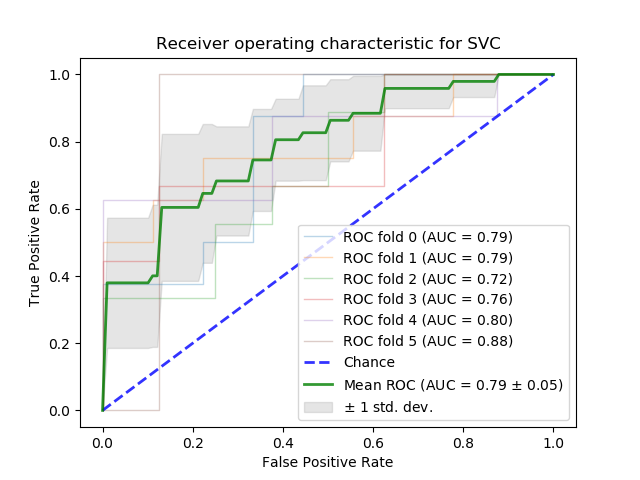

In [1]:
%matplotlib notebook
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='green',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic for {}".format(classifier.__class__.__name__))
ax.legend(loc="lower right")
plt.show()

In [1]:
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.22.


In [ ]:
#pip install -U scikit-learn

In [3]:
from goatools.godag.go_tasks import get_go2parents

GO_ID = 'GO:0008150'  # regulation of metabolic process - 0019222
optional_relationships = set()
go2parents_isa = get_go2parents(godag, optional_relationships)
print(go2parents_isa)

ImportError: cannot import name 'get_go2parents' from 'goatools.godag.go_tasks' (/Users/iftahperetz/opt/anaconda3/lib/python3.7/site-packages/goatools-0.9.9-py3.7.egg/goatools/godag/go_tasks.py)

In [26]:
def ppp():
    print(godag['GO:0008150'])

In [38]:
tmp_gosubdag = GoSubDag('GO:0048522', godag, relationships=False, prt=False)
tmp_gosubdag.rcntobj.go2parents['GO:0048522']

{'GO:0008150', 'GO:0048518', 'GO:0050789', 'GO:0050794', 'GO:0065007'}

In [57]:
def build_godag_isa():
        #Now build the hierarchy, meaning each node is represented by the no. of all its descendants
    genes2terms = pd.DataFrame()
    gene2terms = {}
    for index, row in gene2sl.iterrows():
        for gene in row['genes'].split("$"):
            #No such gene, build it
            if gene not in gene2terms:
                go_ids = gene2goid.get(gene)
                if go_ids is None:
                    print("Could not find the gene {} in GAF".format(gene))               
                else:
                    gene2terms[gene] = {}
                    for go_id in go_ids:
                        #go_id = 'GO:0048522'
                        term = godag.get(go_id)
                        if term.namespace == 'biological_process':
                            # Create a subset of the GO DAG which contains:
                            # The selected GO term and the 'is_a' GO terms above it, by setting relationships=False
                            gosubdag = GoSubDag(go_id, godag, relationships=False, prt=False) 
                            ancestors = defaultdict(set)
                            if go_id in gosubdag.rcntobj.go2parents:
                                for p_go in gosubdag.rcntobj.go2parents[go_id]:
                                    dict_anc = gosubdag.go2nt[p_go]._asdict()
                                    ancestors[dict_anc['depth']].add(dict_anc['GO'])
                            #print(ancestors)       
                            #Get the leaf GO term
                            if go_id not in gene2terms[gene]:
                                gene2terms[gene][go_id] = 1
                            else:
                                gene2terms[gene][go_id] += 1
                            #Sum up all the ancestors values
                            count_genes = 1  
                            for level in range(len(ancestors) - 1, -1, -1):
                                for GO in ancestors[level]:
                                    if GO not in gene2terms[gene]:
                                        gene2terms[gene][GO] = count_genes
                                    else:
                                        gene2terms[gene][GO] += count_genes                                
                                count_genes += len(ancestors[level])  

        #Build the combination of the 2 genes
        g1, g2 = row['genes'].split("$")
        gene1 = gene2terms[g1]
        gene2 = gene2terms[g2]             
        genesdict = {key: gene1.get(key, 0) + gene2.get(key, 0)
                     for key in set(gene1) | set(gene2)}
        #print(genesdict)
        genesdict['genes'] = row['genes']
        genesdict['sl'] = row['sl']
        #Add the final line and clean NaN
        genes2terms = genes2terms.append(genesdict, ignore_index=True)
        genes2terms = genes2terms.fillna(0)
        #print(genes2terms)
        #break
        if index == 10: break

In [58]:
%prun build_godag_isa()

In [59]:
genes2terms

,genes,sl
0,YAL002W$YAL011W,0.0
1,YAL002W$YAL013W,0.0
2,YAL002W$YAL019W,0.0
3,YAL002W$YAL021C,0.0
4,YAL002W$YAL058W,0.0
...,...,...
996,YAL013W$YJL139C,0.0
997,YAL013W$YJL148W,0.0
998,YAL013W$YJL154C,0.0
999,YAL013W$YJL166W,0.0


In [60]:
import numpy as np
outfile = 'mnmc_lite.features.npz'
npzfile = np.load(outfile)

In [61]:
npzfile.files

['features', 'overlay_features']

In [68]:
npzfile['features'].shape

(134275, 5)

In [67]:
npzfile['overlay_features'].shape

(134275, 10)

In [51]:
df22  = pd.DataFrame()
ll = []
ll.append({'GO:001':1, 'GO:004':4})
ll.append({'GO:003':3, 'GO:005':5})
df22 = df22.append(ll, ignore_index=True)
df22 = df22.fillna(0)
df22

,GO:001,GO:004,GO:003,GO:005
0,1.0,4.0,0.0,0.0
1,0.0,0.0,3.0,5.0


In [ ]:
# import pandas as pd
# import numpy as np

# df = pd.DataFrame([{'c1':10, 'c2':100}, {'c1':11,'c2':110}, {'c1':12,'c2':120}])
# for index, row in df.iterrows():
#     print(str(index) + '\n')
#     print(row['c1'], row['c2'])
# df = pd.DataFrame(columns=['lib', 'qty1', 'qty2', 'qty3', 'qty4'])
# df2 = pd.DataFrame(columns=['lib', 'qty1', 'qty2'])
# for i in range(5):
#     df2.loc[i] = ['name' + str(i)] + list(randint(10, size=2))
# df3 = pd.DataFrame(columns=['lib', 'qty1', 'qty2'])
# for i in range(5):
#     df3.loc[i] = ['name' + str(i)] + list(randint(10, size=2))
# df.loc[0] = df2[df2.lib == 'name0'] + df3[df3.lib == 'name0'] 
# df
# df2
# df3

In [ ]:
# List of Tuples
students = [ ('jack', 34, 'Sydeny' , 'Australia') ,
             ('Riti', 30, 'Delhi' , 'India' ) ,
             ('Vikas', 31, 'Mumbai' , 'India' ) ,
             ('Neelu', 32, 'Bangalore' , 'India' ) ,
             ('John', 16, 'New York' , 'US') ,
             ('Mike', 17, 'las vegas' , 'US')  ]
#print('{NS} {GO} D{depth:02} {GO_name}'.format(**gosubdag.go2nt[p_go]._asdict()))
#Create a DataFrame object
dfObj = pd.DataFrame(students, columns = ['Name' , 'Age', 'City' , 'Country'], index=['a', 'b', 'c' , 'd' , 'e' , 'f'])
# Pass the row elements as key value pairs to append() function 
dfObj = dfObj.append({'Name' : 'Sahil' , 'City' : 'my butt'} , ignore_index=True)

In [ ]:
ty = defaultdict(set)
ty['YW2'] = {'go0001':1, 'go0002':3}
'YW2' not in ty

In [ ]:
dict1 = {'a': 5, 'b': 7}
dict2 = {'a': 3, 'c': 1}

result = {key: dict1.get(key, 0) + dict2.get(key, 0)
          for key in set(dict1) | set(dict2)}
result['genes'] = 'YSYD$YSHS2'
result['sl'] = 0
ff = pd.DataFrame()
ff = ff.append(result, ignore_index=True)
ff = ff.append({}, ignore_index=True)
ff = ff.fillna(0)

/Users/iftahperetz/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/iftahperetz/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

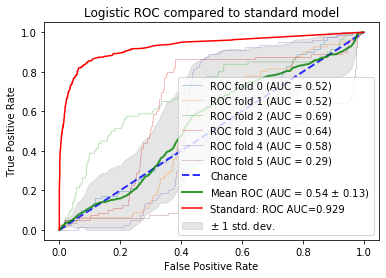

In [9]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

genes2terms = pd.DataFrame()
genes2terms = pd.read_pickle("genes2terms.pkl")
genes2terms = genes2terms.set_index('genes')
#Get the standard model to which we are comparing
standard_model = pd.read_csv('all.onto_genes.features.cv_all.rf.predictions', header=None, names=["prob"])
standard_model['sl'] = -1
standard_model.loc[standard_model['prob'] >= 0.5,'sl'] = 1
standard_model.loc[standard_model['prob'] < 0.5,'sl'] = 0
standard_model['pairs'] = genes2terms.index.values
standard_model = standard_model.set_index('pairs')
standard_model = standard_model.head(5000)
# Set the X, y data
X = genes2terms.drop(['sl'], axis=1)
y = genes2terms['sl']
X = X.head(5000)
y = y.head(5000)
# Run classifier with cross-validation  
cv = StratifiedKFold(n_splits=6)
classifier = LogisticRegression(solver='lbfgs', max_iter=50)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    #Fit the model
    classifier.fit(X.iloc[train], y.iloc[train])
    #Get the predictions and keep AUC values for later plot
    viz = plot_roc_curve(classifier, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

# Plot ROC curves        
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='green',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
#Now the standard model
standard_auc = roc_auc_score(y, standard_model['prob'])
#print('Standard: ROC AUC=%.3f' % (standard_auc))
base_fpr, base_tpr, _ = roc_curve(y, standard_model['prob'])
ax.plot(base_fpr, base_tpr, label=r'Standard ROC (AUC=%.3f)' % (standard_auc), color='red')
#Design of plot
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Logistic ROC compared to standard model")
ax.legend(loc="lower right")
plt.show()    